# 0. Install and Import Dependencies

In [1]:
#!pip list

In [2]:
#!pip install opencv-python matplotlib imageio gdown tensorflow

In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [6]:
import gdown

In [7]:
#url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
#output = 'data.zip'
#gdown.download(url, output, quiet=False)
#gdown.extractall('data.zip')

In [8]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [9]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [10]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [11]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [12]:
char_to_num(['s','a','k','t','h','i'])

<tf.Tensor: shape=(6,), dtype=int64, numpy=array([19,  1, 11, 20,  8,  9], dtype=int64)>

In [13]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [14]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [20]:
test_path = './data/s1/bbal6n.mpg'

In [21]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [22]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

UnknownError: {{function_node __wrapped__Sub_device_/job:localhost/replica:0/task:0/device:GPU:0}} JIT compilation failed. [Op:Sub]

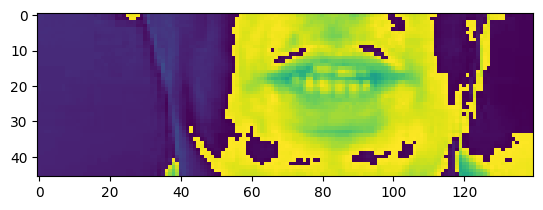

In [ ]:
plt.imshow(frames[40])

In [ ]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [23]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [24]:
from matplotlib import pyplot as plt

In [25]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(1, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(50)
test = data.skip(50)

In [26]:
len(test)

951

In [27]:
frames, alignments = data.as_numpy_iterator().next()

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} FileNotFoundError: [Errno 2] No such file or directory: 'data\\alignments\\s1\\.align'
Traceback (most recent call last):

  File "c:\Users\Asus\.conda\envs\lipnet\lib\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    return func(device, token, args)

  File "c:\Users\Asus\.conda\envs\lipnet\lib\site-packages\tensorflow\python\ops\script_ops.py", line 147, in __call__
    outputs = self._call(device, args)

  File "c:\Users\Asus\.conda\envs\lipnet\lib\site-packages\tensorflow\python\ops\script_ops.py", line 154, in _call
    ret = self._func(*args)

  File "c:\Users\Asus\.conda\envs\lipnet\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\Asus\AppData\Local\Temp\ipykernel_24392\704668053.py", line 9, in load_data
    alignments = load_alignments(alignment_path)

  File "C:\Users\Asus\AppData\Local\Temp\ipykernel_24392\885867866.py", line 2, in load_alignments
    with open(path, 'r') as f:

  File "c:\Users\Asus\.conda\envs\lipnet\lib\site-packages\IPython\core\interactiveshell.py", line 286, in _modified_open
    return io_open(file, *args, **kwargs)

FileNotFoundError: [Errno 2] No such file or directory: 'data\\alignments\\s1\\.align'


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext]

In [ ]:
len(frames)

1

In [ ]:
sample = data.as_numpy_iterator()

In [ ]:
val = sample.next(); val[0]

array([[[[[1.4703741 ],
          [1.4345113 ],
          [1.3986485 ],
          ...,
          [0.32276505],
          [0.32276505],
          [0.32276505]],

         [[1.5062369 ],
          [1.4703741 ],
          [1.3986485 ],
          ...,
          [0.32276505],
          [0.32276505],
          [0.32276505]],

         [[1.5062369 ],
          [1.5062369 ],
          [1.3627858 ],
          ...,
          [0.4303534 ],
          [0.35862783],
          [0.35862783]],

         ...,

         [[1.0400207 ],
          [1.0400207 ],
          [1.0400207 ],
          ...,
          [0.10758835],
          [0.10758835],
          [0.10758835]],

         [[1.0041579 ],
          [1.0041579 ],
          [1.0041579 ],
          ...,
          [0.10758835],
          [0.10758835],
          [0.10758835]],

         [[1.0041579 ],
          [1.0041579 ],
          [1.0041579 ],
          ...,
          [0.10758835],
          [0.10758835],
          [0.07172557]]],


        [[[1.5062

In [ ]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

TypeError: Cannot handle this data type: (1, 1, 1), <f4

In [ ]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

# 3. Design the Deep Neural Network

In [ ]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, Activation, MaxPool3D, TimeDistributed, Flatten, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
model = Sequential([
    Conv3D(64, 3, input_shape=(75, 46, 140, 1), padding='same', activation='relu'),
    MaxPool3D((1, 2, 2)),
    Conv3D(128, 3, padding='same', activation='relu'),
    MaxPool3D((1, 2, 2)),
    Conv3D(75, 3, padding='same', activation='relu'),
    MaxPool3D((1, 2, 2)),
    TimeDistributed(Flatten()),
    Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)),
    Dropout(0.5),
    Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 64)   1792      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 64)   0         
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 64)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 64)    110656    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 64)    0         
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 75, 11, 35, 64)    0         
 g3D)                                                   

6375

In [ ]:
yhat = model.predict(val[0])

1/1 [==============================] - 1s 1s/step


In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'112222222222222222222222222222222222222222222222222222222222222222222dddddd'>

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'112222222222222222222222222222222222222222222222222222222222222222222dddddd'>

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [ ]:
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback])

Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 111.9638

[mpeg1video @ 0x7f5d78034f00] ac-tex damaged at 22 17
[mpeg1video @ 0x7f5d78034f00] Warning MVs not available


KeyboardInterrupt: 

# 5. Make a Prediction 

In [ ]:
model.load_weights('models/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

# Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]